In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Datasets:
## 1. NYC 311 - Service Requests dataset
(bigquery-public-data:new_york_311.311_service_requests)   
This data includes all New York City 311 service requests from 2010 to the present, and is updated daily. 311 is a non-emergency number that provides access to non-emergency municipal services.

## 2. NYPD Motor Vehicle Collisions
(bigquery-public-data:new_york_mv_collisions.nypd_mv_collisions)   
This dataset includes details of Motor Vehicle Collisions in New York City provided by the Police Department (NYPD) from 2012 to the present. This dataset is updated daily.   

## 3. NY Taxi Trips  
(bigquery-public-data:new_york_taxi_trips)   
Contains the taxi-trips data for the various lines. The data is distributed in multiple files.


Querying data from BigQuery for the first time, Saving it in a CSV offline. 

In [3]:
#from google.cloud import bigquery
#client = bigquery.Client()
#sql = """
#SELECT * FROM `bigquery-public-data.new_york_311.311_service_requests` LIMIT 10000
#"""
#df_311 = client.query(sql).to_dataframe()


In [4]:
df_311 = pd.read_csv('data/df_311_data.csv')

### Exploratory Data Analysis

Looking at a single Latitude Longitude point 

In [5]:
df_311['latitude'][0], df_311['longitude'][0]

(40.8174358917541, -73.91680405885789)

**Categorical Features:** location_Type, complaint_type, agency_name, agency, incident_zip

Creating a Zip Dictionary. It shows the number of complaints in each zip code area.

In [6]:
zipdict = dict(df_311.groupby('incident_zip')['unique_key'].nunique())

In [7]:
zipapp = []
for i in range(len(df_311)):
    try:
        zipapp.append(zipdict[df_311['incident_zip'][i]])
    except:
        zipapp.append(None)

df_311['inc_in_region'] = zipapp

Since, every request has a location type, we find out how many requests have been put in for the similar location types. 

In [8]:
typedict = df_311.groupby('location_type')['unique_key'].nunique()

In [9]:
typeapp = []
for i in range(len(df_311)):
    try:
        typeapp.append(typedict[df_311['location_type'][i]])
    except:
        typeapp.append(None)

df_311['inc_per_location_type'] = typeapp

Similarly with agency_name, since it has unique values, we can find out and append a column with the total requests for each agency name.   
**Since we have been doing the same operation repeatedly, now is the time to actually create a function for it.**

In [10]:
def func_totalrows(name):
    typedict = df_311.groupby(name)['unique_key'].nunique()
    typeapp = []
    for i in range(len(df_311)):
        try:
            typeapp.append(typedict[df_311[name][i]])
        except:
            typeapp.append(None)
    return typeapp

In [11]:
df_311['agency_name'].unique()

array(['Department of Health and Mental Hygiene',
       'New York City Police Department', 'Department for the Aging',
       'Operations Unit - Department of Homeless Services',
       'HealthCare Connections',
       'Department of Housing Preservation and Development',
       'Department of Transportation',
       'Child Care and Camps Complaint Unit',
       'Department of Parks and Recreation', 'A - Bronx',
       'School - Family Life Academy Charter School II',
       'Department of Consumer Affairs', 'School - PS 43 Jonas Bronck',
       'Taxi and Limousine Commission',
       'Department of Environmental Protection', 'BCC - Bronx',
       'Land Records', 'Correspondence Unit', 'Refunds and Adjustments',
       'Senior Citizen Rent Increase Exemption Unit',
       'A - Canine Task Force Citywide', 'Department of Buildings',
       'Disability Rent Increase Exemption Unit',
       'Personal Exemption Unit', 'Commercial Exemption Unit',
       'P - Manhattan and Bronx', '3-1-1 C

In [12]:
df_311['inc_per_agency'] = func_totalrows('agency_name')

In [13]:
df_311['inc_per_complaint_type'] = func_totalrows('complaint_type')

Agency and Agency_name are similar, so I can ignore it.

Plotting New York City Map and all the points

In [14]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

In [15]:
street_map = gpd.read_file('ShapeFiles/nyu_2451_34505.shp')

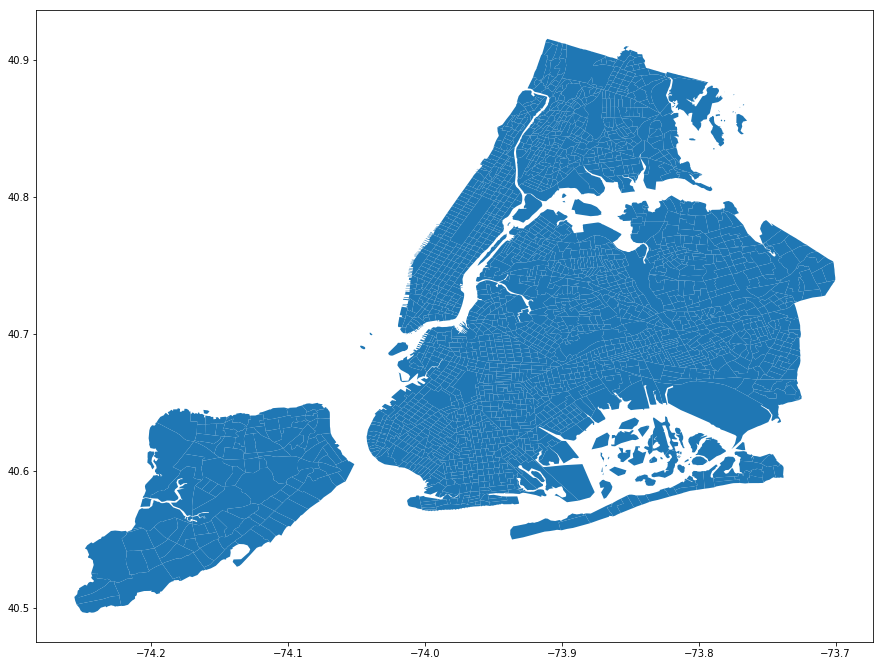

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax = ax)

In [17]:
geometry = [Point(xy) for xy in zip(df_311['longitude'], df_311['latitude'])]  #Creates a Point Object that can be plotted
crs = {'init':'epsg:4326'}
geodf = gpd.GeoDataFrame(df_311, crs=crs, geometry=geometry)  #GeoDataFrame can be plotted on the Map

In [25]:
#geodf[['agency']]

In [19]:
geodf.columns

Index(['Unnamed: 0', 'unique_key', 'created_date', 'closed_date', 'agency',
       'agency_name', 'complaint_type', 'descriptor', 'location_type',
       'incident_zip', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'intersection_street_1', 'intersection_street_2',
       'address_type', 'city', 'landmark', 'facility_type', 'status',
       'due_date', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate', 'y_coordinate',
       'park_facility_name', 'park_borough', 'bbl', 'open_data_channel_type',
       'vehicle_type', 'taxi_company_borough', 'taxi_pickup_location',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment', 'latitude', 'longitude', 'location',
       'inc_in_region', 'inc_per_location_type', 'inc_per_agency',
       'inc_per_complaint_type', 'geometry'],
      dtype='object')

### Plotting the Agencies and Request they get from various regions

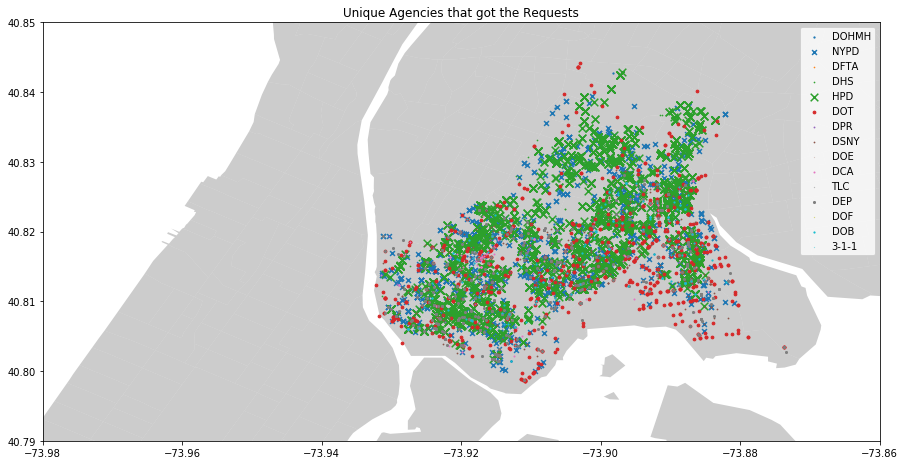

In [18]:
#Unique Colors
unique_agencies = list(geodf['agency'].unique())
NUM_COLORS = len(unique_agencies)
cm = plt.cm.get_cmap('tab10', NUM_COLORS)
dd = dict()
for i in range(NUM_COLORS):
    dd[unique_agencies[i]] = cm(i)


#Unique Sizes based on # of Requests handled by the Agency
sizes = []
for each in geodf['agency'].unique():
    sizes.append(geodf[geodf['agency'] == each]['inc_per_agency'].reset_index()['inc_per_agency'][0])
sizes2 = [float(i)/sum(sizes)*100 for i in sizes]

#Unique markers => 'x' for Agencies with more Requests and 'o' otherwise
markers = []
for each in sizes2:
    if(each < np.mean(sizes2)*2):
        markers.append('o')
    else:
        markers.append('x')
    

fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
for i in range(len(unique_agencies)):
    geodf[geodf['agency'] == unique_agencies[i]]['geometry'].plot(ax=ax, markersize=sizes2[i],
                                                   color=dd[unique_agencies[i]], marker=markers[i], label=unique_agencies[i])

minx, miny, maxx, maxy = -73.98, 40.79, -73.86, 40.85
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.title('Unique Agencies that got the Requests')
plt.legend()
plt.show()

The plot shows that the 'Department of Housing Preservation and Development' and 'New York City Police Department' receive the most Requests. Besides that, Department of Health and Mental Hygience follow.

In [19]:
#geodf['agency_name'].unique()

### Now, let's try to anaylze the Incidents per region/zip

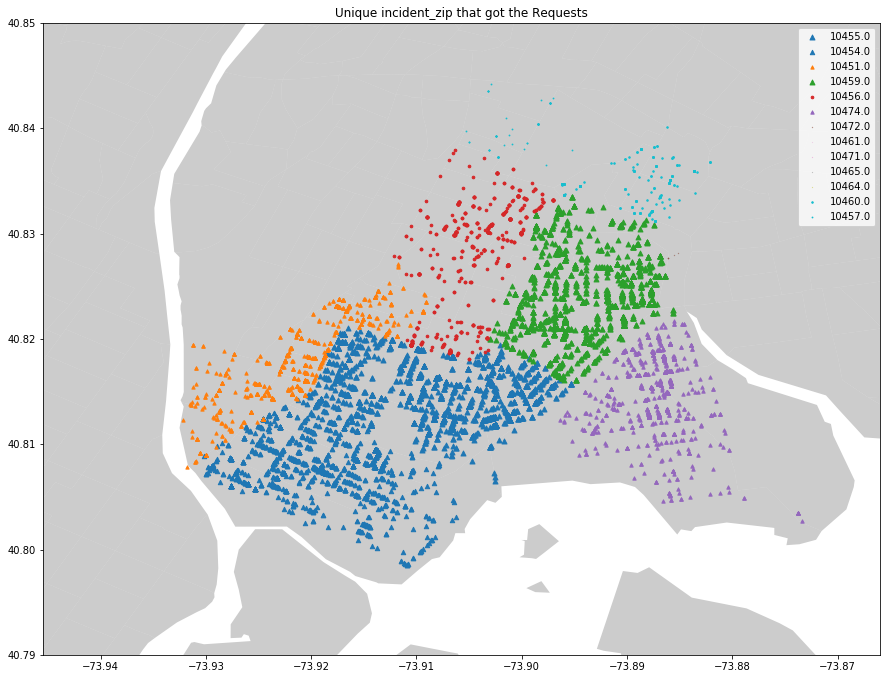

In [20]:
feature = 'incident_zip'
incfeature = 'inc_in_region'
#Unique Colors
unique_agencies = list(geodf[feature].unique())
NUM_COLORS = len(unique_agencies)
cm = plt.cm.get_cmap('tab10', NUM_COLORS)
dd = dict()
for i in range(NUM_COLORS):
    dd[unique_agencies[i]] = cm(i)

#Unique Sizes based on # of Requests handled
sizes = []
for each in geodf[feature].unique():
    try:
        sizes.append(geodf[geodf[feature] == each][incfeature].reset_index()[incfeature][0])
    except:
        sizes.append(0)
sizes2 = [float(i)/sum(sizes)*100 for i in sizes]

#Unique markers => 'x' for Agencies with more Requests and 'o' otherwise
markers = []
for each in sizes2:
    if(each < np.mean(sizes2)):
        markers.append('o')
    else:
        markers.append('^')


fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
for i in range(len(unique_agencies)):
    geodf[geodf[feature] == unique_agencies[i]]['geometry'].plot(ax=ax, markersize=sizes2[i],
                                                   color=dd[unique_agencies[i]], marker=markers[i], label=unique_agencies[i])

minx, miny, maxx, maxy = -73.9455, 40.79, -73.866, 40.85
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.title('Unique '+feature+' that got the Requests')
plt.legend()
plt.show()

The above plot makes it clear as to which region send most requests.

### Plotting per Location

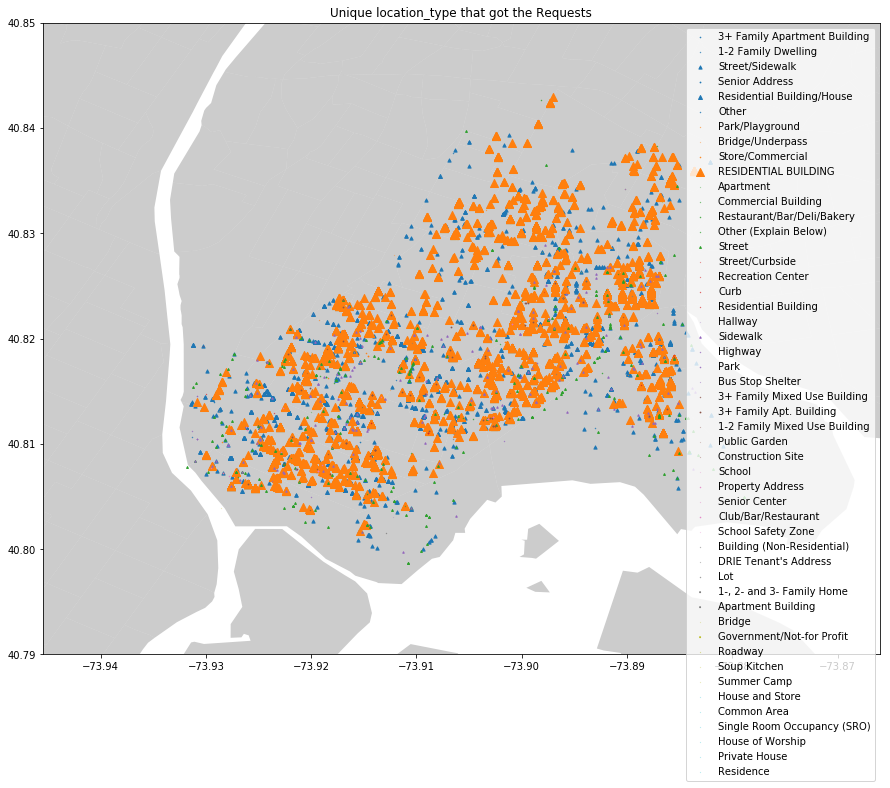

In [21]:
feature = 'location_type'
incfeature = 'inc_per_location_type'
#Unique Colors
unique_agencies = list(geodf[feature].unique())
NUM_COLORS = len(unique_agencies)
cm = plt.cm.get_cmap('tab10', NUM_COLORS)
dd = dict()
for i in range(NUM_COLORS):
    dd[unique_agencies[i]] = cm(i)

#Unique Sizes based on # of Requests handled
sizes = []
for each in geodf[feature].unique():
    try:
        sizes.append(geodf[geodf[feature] == each][incfeature].reset_index()[incfeature][0])
    except:
        sizes.append(0)
sizes2 = [float(i)/sum(sizes)*100 for i in sizes]

#Unique markers => 'x' for Agencies with more Requests and 'o' otherwise
markers = []
for each in sizes2:
    if(each < np.mean(sizes2)):
        markers.append('o')
    else:
        markers.append('^')


fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
for i in range(len(unique_agencies)):
    try:
        geodf[geodf[feature] == unique_agencies[i]]['geometry'].plot(ax=ax, markersize=sizes2[i],
                                                   color=dd[unique_agencies[i]], marker=markers[i], label=unique_agencies[i])
    except:
        pass

minx, miny, maxx, maxy = -73.9455, 40.79, -73.866, 40.85
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.title('Unique '+feature+' that got the Requests')
plt.legend()
plt.show()

### Now, I need to know as to what type of Requests are generated in the different regions

Find out what are the most complaint types

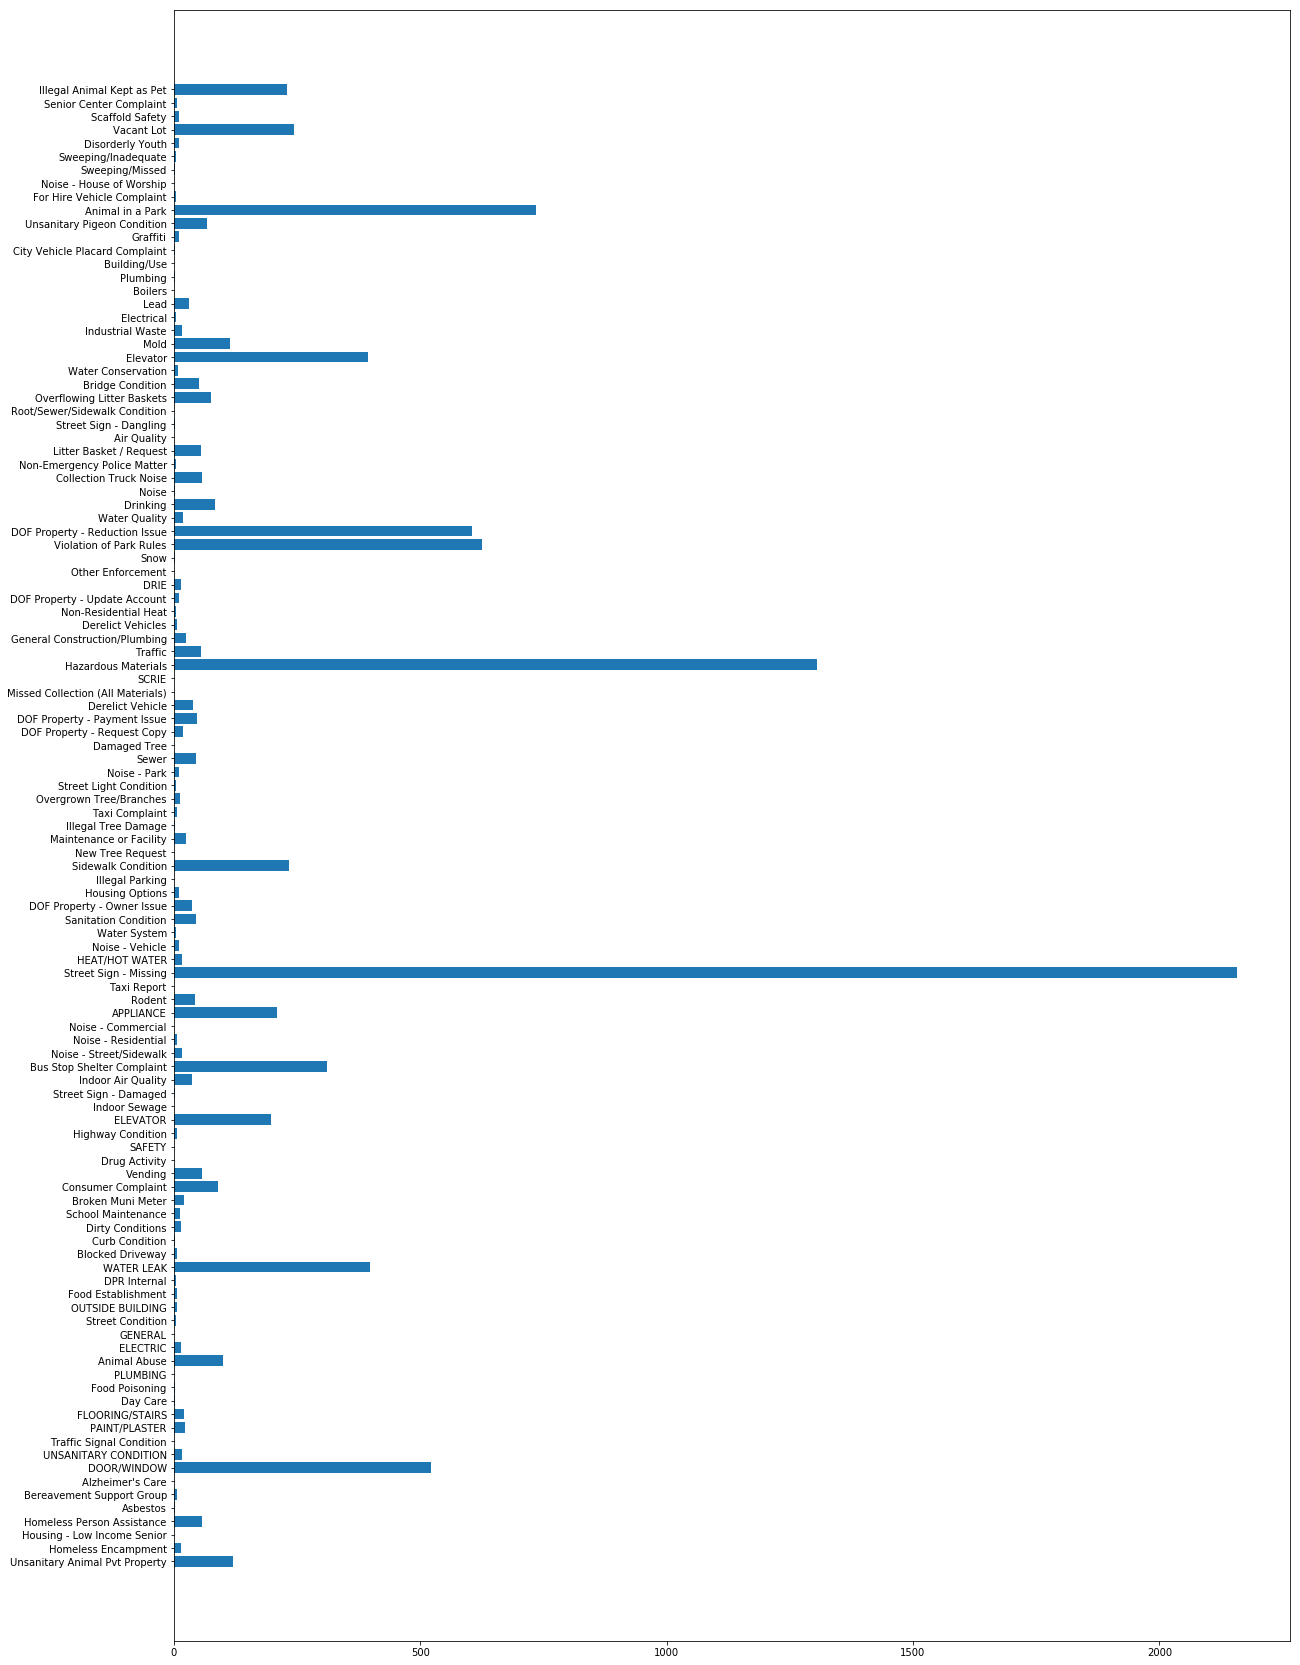

In [22]:
plt.figure(figsize=(20, 30))
plt.barh(list(geodf.complaint_type.unique()), 
        list(geodf.groupby('complaint_type')['unique_key'].nunique().values))
plt.show()

Looking at the barplot, the complaints with atleast 400 requests will be considered ahead.

In [23]:
compdict = dict()
k = list(geodf.complaint_type.unique())
v = list(geodf.groupby('complaint_type')['unique_key'].nunique().values)
for i in range(len(k)):
    compdict[k[i]] = v[i]

In [24]:
#take the complaint_type greater than 400
comp = []
for key in compdict.keys():
    if(compdict[key] >= 200):
        comp.append(key)

In [25]:
geodf2 = geodf[geodf['complaint_type'].isin(comp)].reset_index()

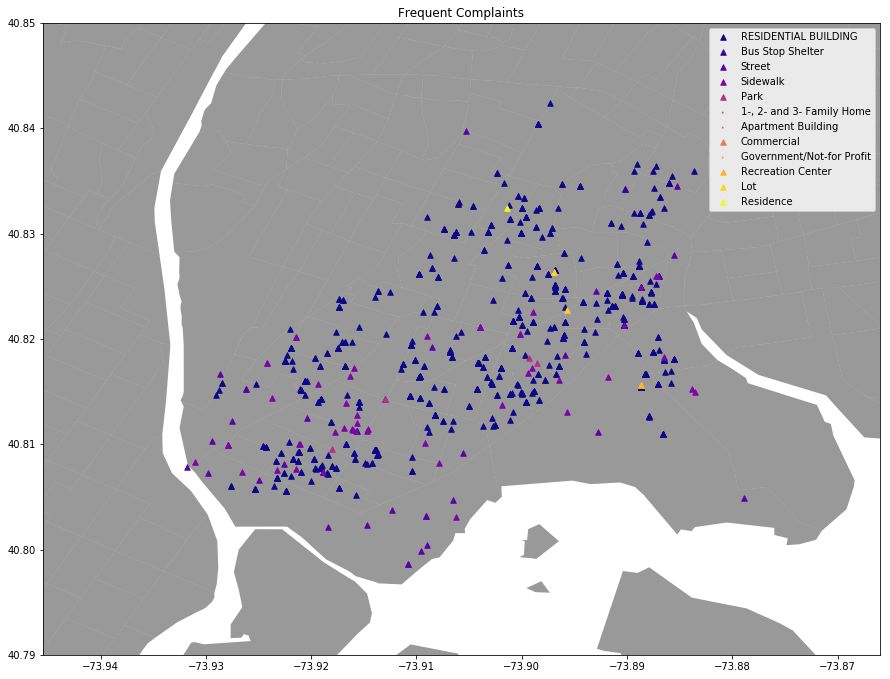

In [26]:
### feature = 'complaint_type'
incfeature = 'inc_per_complaint_type'
#Unique Colors
unique_agencies = list(geodf2[feature].unique())
NUM_COLORS = len(unique_agencies)
cm = plt.cm.get_cmap('plasma', NUM_COLORS)
dd = dict()
for i in range(NUM_COLORS):
    dd[unique_agencies[i]] = cm(i)


fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax, alpha=0.4, color='black')
for i in range(len(unique_agencies)):
    geodf2[geodf2[feature] == unique_agencies[i]]['geometry'].plot(ax=ax, markersize=30,
                                                   color=dd[unique_agencies[i]], marker='^', label=unique_agencies[i])

minx, miny, maxx, maxy = -73.9455, 40.79, -73.866, 40.85
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.title('Frequent Complaints')
plt.legend()
plt.show()

### Given the type of Issue/Complaint which Agency was it assigned to

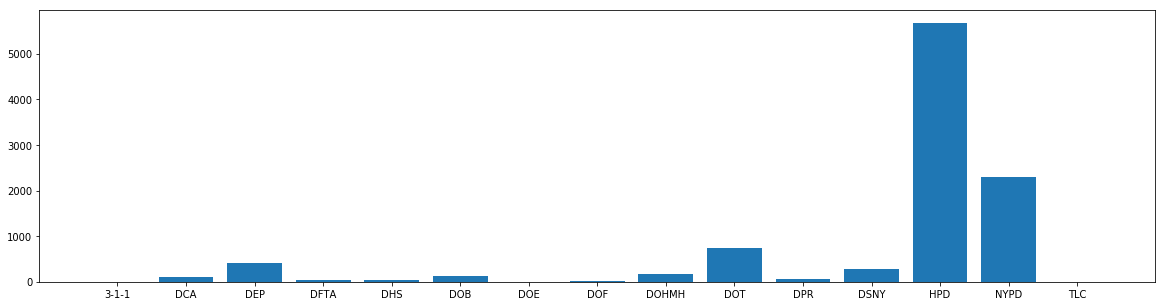

In [27]:
compAgency = geodf[['agency', 'complaint_type']].groupby('agency').count()
plt.figure(figsize=(20, 5))
plt.bar(compAgency.index, compAgency['complaint_type'])
plt.show()

Clearly, HPD and NYPD receive the most requests/complaints.

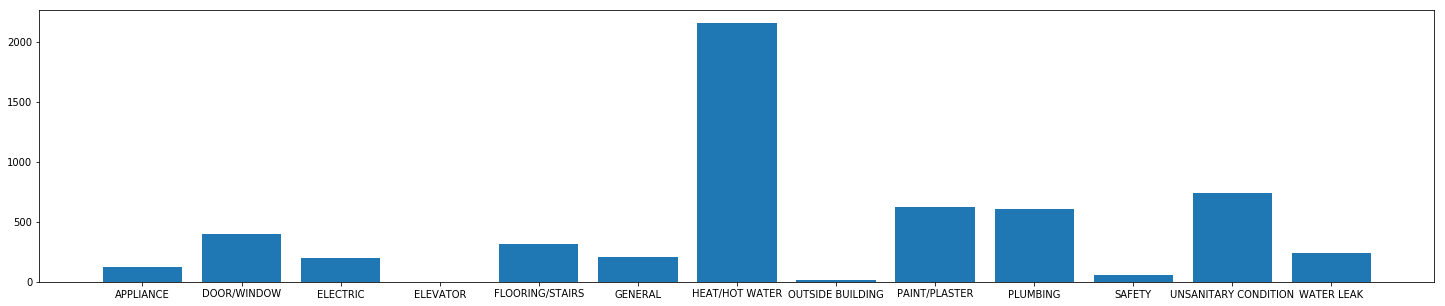

In [28]:
hpdAgency = geodf[geodf['agency'] == 'HPD'].groupby('complaint_type').count()
plt.figure(figsize=(25, 5))
plt.bar(hpdAgency.index, hpdAgency.unique_key)
plt.show()

HPD gets most complaint about Heat/Hot Water followed by Unsanitart Conditions, Painting/Plastering and Plumbing issues.

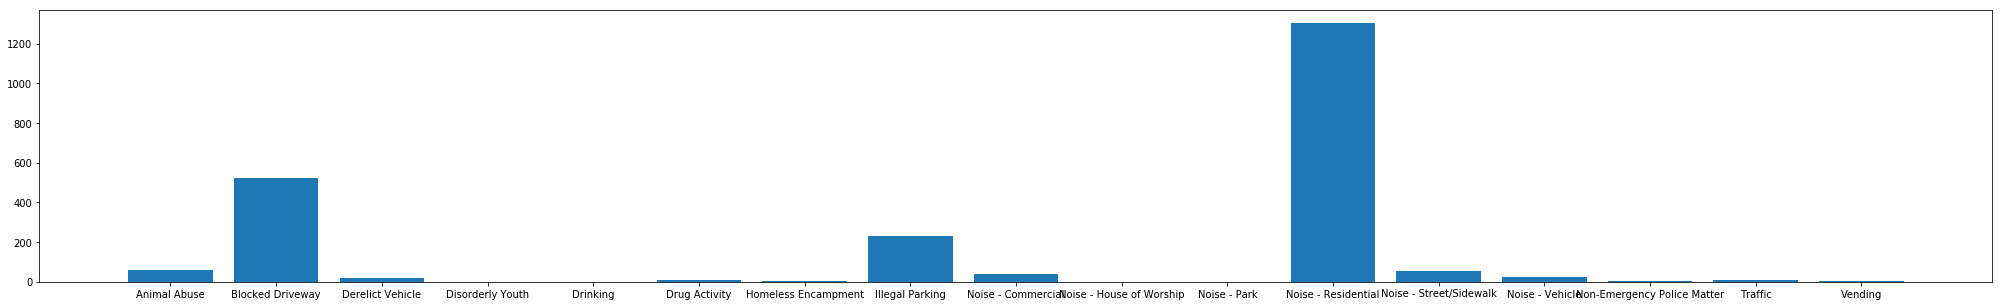

In [29]:
nypdAgency = geodf[geodf['agency'] == 'NYPD'].groupby('complaint_type').count()
plt.figure(figsize=(35, 5))
plt.bar(nypdAgency.index, nypdAgency.unique_key)
plt.show()

NYPD gets most complaints about Residential noise, Blocked driveway, and Illegal parking.

At what time of the Day have you received the complaints.

## Problem Statement - Creating a Regression model that can predict the time taken to complete a particular Request.

### Data Preprocessing

In [35]:
from datetime import datetime

In [49]:
t = datetime.strptime('2016-11-29 00:00:00', '%Y-%m-%d %H:%M:%S') - datetime.strptime('2016-11-18 00:00:00', '%Y-%m-%d %H:%M:%S')


In [50]:
t.days, t.seconds

(11, 0)

In [32]:
geodf[['created_date', 'closed_date']].head()

,created_date,closed_date
0,2016-11-18 00:00:00+00:00,2016-11-29 00:00:00+00:00
1,2016-11-18 00:00:00+00:00,2016-11-29 00:00:00+00:00
2,2016-12-31 00:00:00+00:00,2017-01-12 00:00:00+00:00
3,2016-11-03 14:14:39+00:00,2016-11-03 21:30:54+00:00
4,2016-11-08 16:37:51+00:00,2016-11-09 12:44:50+00:00


Changed the format of the date

In [73]:
def change_date(date):
    try:
        return date[:-6]
    except:
        return None

In [75]:
geodf['created_date'] = geodf['created_date'].apply(change_date)

In [76]:
geodf['closed_date'] = geodf['closed_date'].apply(change_date)

Time taken in minutes. The ones with no closed_date values, their time_taken is taken as 0. So, they must be removed while model building.

In [87]:
def find_time_taken(created_date, closed_date):
    to_ret = 0
    if(closed_date is not None and created_date is not None):
        t = datetime.strptime(closed_date, '%Y-%m-%d %H:%M:%S') - datetime.strptime(created_date, '%Y-%m-%d %H:%M:%S')
        if(t.days != 0):
            to_ret += (t.days * 24 * 60)
        if(t.seconds != 0):
            to_ret += (t.seconds / 60)
    return round(to_ret/60, 3)

In [88]:
tt = []

for i in range(len(geodf)):
    tt.append(find_time_taken(geodf['created_date'][i], geodf['closed_date'][i]))

In [90]:
geodf['time_taken'] = tt

In [109]:
datadf = geodf[['unique_key', 'created_date', 'closed_date', 'due_date', 'agency',
       'agency_name', 'complaint_type', 'location_type',
       'incident_zip', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'intersection_street_1', 'intersection_street_2',
       'address_type', 'city', 'landmark', 'facility_type',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough',
       'park_facility_name', 'park_borough', 'bbl', 'open_data_channel_type',
       'vehicle_type', 'taxi_company_borough', 'taxi_pickup_location',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment', 'latitude', 'longitude', 'location',
       'inc_in_region', 'inc_per_location_type', 'inc_per_agency',
       'inc_per_complaint_type', 'time_taken']]

### Dealing with Categorical variables and looking at it's coorelation with the Time taken.

City - Look at the coorelation between most frequent and least cities to Timetaken, and also look at the overall coorelation between all cities and Time taken. The highly coorelated cities will be taken for One-Hot Encoding.

In [97]:
datadf['city'].unique()

array(['BRONX', nan, 'BROOKLYN'], dtype=object)

In [112]:
print("Rows with Null values for city", datadf[datadf['city'].isnull() == True]['unique_key'].count())

Rows with Null values for city 7


Looking at other Address features

In [117]:
datadf[['location_type', 'incident_zip', 'incident_address', 'street_name', 'cross_street_1', 'cross_street_2', 'intersection_street_1',\
       'intersection_street_2', 'address_type', 'landmark', 'facility_type']].head()


,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,landmark,facility_type
0,3+ Family Apartment Building,10455.0,415 EAST 151 STREET,EAST 151 STREET,MELROSE AVENUE,3 AVENUE,NaN,NaN,ADDRESS,NaN,NaN
1,3+ Family Apartment Building,10455.0,415 EAST 151 STREET,EAST 151 STREET,MELROSE AVENUE,3 AVENUE,NaN,NaN,ADDRESS,NaN,NaN
2,1-2 Family Dwelling,10454.0,446 EAST 142 STREET,EAST 142 STREET,WILLIS AVENUE,BROOK AVENUE,NaN,NaN,ADDRESS,NaN,NaN
3,Street/Sidewalk,10455.0,NaN,NaN,NaN,NaN,MELROSE AVENUE,EAST 149 STREET,INTERSECTION,NaN,Precinct
4,Senior Address,10455.0,NaN,NaN,NaN,NaN,NaN,NaN,ADDRESS,NaN,NaN


In [114]:
print("Rows with Null values for Zip code", datadf[datadf['incident_zip'].isnull() == True]['unique_key'].count())

Rows with Null values for Zip code 8


In [116]:
print("Rows with Null values for incident_address", datadf[datadf['incident_address'].isnull() == True]['unique_key'].count())
print("Rows with Null values for street_name", datadf[datadf['street_name'].isnull() == True]['unique_key'].count())
print("Rows with Null values for cross_street_1", datadf[datadf['cross_street_1'].isnull() == True]['unique_key'].count())
print("Rows with Null values for cross_street_2", datadf[datadf['cross_street_2'].isnull() == True]['unique_key'].count())
print("Rows with Null values for intersection_street_1", datadf[datadf['intersection_street_1'].isnull() == True]['unique_key'].count())
print("Rows with Null values for intersection_street_2", datadf[datadf['intersection_street_2'].isnull() == True]['unique_key'].count())
print("Rows with Null values for address_type", datadf[datadf['address_type'].isnull() == True]['unique_key'].count())
print("Rows with Null values for landmark", datadf[datadf['landmark'].isnull() == True]['unique_key'].count())
print("Rows with Null values for facility_type", datadf[datadf['facility_type'].isnull() == True]['unique_key'].count())

Rows with Null values for incident_address 699
Rows with Null values for street_name 699
Rows with Null values for cross_street_1 6564
Rows with Null values for cross_street_2 6569
Rows with Null values for intersection_street_1 9396
Rows with Null values for intersection_street_2 9396
Rows with Null values for address_type 37
Rows with Null values for landmark 10000
Rows with Null values for facility_type 7500


Looking at the figures, we can take city, incident_zip, address_type for consideration of model confidently. Besides them, even incident_address and street_name can be combined and looked into to see if they have any correlation with the Time taken. Other than these, all other features can be neglected. 

Can't do much about resolution_description here for the Regression model. Needs to be excluded. 'resolution_update_time' will be considered. 

In [134]:
datadf['resolution_description'].unique()[:10]

array(['The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in an inspection.  Please call 311 in 30 days from the date of your complaint for status',
       'The Police Department responded to the complaint and took action to fix the condition.',
       'The Department for the Aging contacted you and provided the assistance requested.Â\xa0 No further updates will be available through 311.   If further assistance is needed, please open a new Service Request.',
       'The Department of Homeless Services has reviewed your Service Request and determined that the issue is not within its jurisdiction.',
       'The mobile outreach response team went to the location provided but could not find the individual that you reported.',
       'The Department of Homeless Services has sent a mobile outreach response team to the location.',
       'The individual was found and outreach assistance was offered.'

vehicle_type, taxi_company_borough, taxi_pickup_location, bridge_highway_name, bridge_highway_direction, road_ramp,    bridge_highway_segment can also be neglected.

'resolution_action_updated_date' can be used as a variable, as to when the Request was updated. See the difference between closed date and updated date, if same then neglect one of them, else the time Difference between Updated and open can be one of the Features.

In [121]:
datadf['resolution_action_updated_date'].head()

0    2016-11-29 00:00:00+00:00
1    2016-11-29 00:00:00+00:00
2    2017-01-12 00:00:00+00:00
3    2016-11-03 21:30:29+00:00
4    2016-11-09 12:44:50+00:00
Name: resolution_action_updated_date, dtype: object

Can't neglect it right-away, look at it when you have larger dataset, and see what unique values you have in it.

In [123]:
datadf['community_board'].unique()

array(['01 BRONX', '02 BRONX', '03 BRONX'], dtype=object)

In [126]:
datadf['borough'].unique()   ##### NEGLECT THIS ONE AS WELL

array(['BRONX'], dtype=object)

In [127]:
datadf['park_facility_name'].unique()

array(['Unspecified', 'School - Family Life Academy Charter School II',
       "Recreation Center - St. Mary's", 'School - PS 43 Jonas Bronck',
       'Patterson Playground', 'Melrose Playground', 'Abigail Playground',
       'Clark Playground', 'Governor Smith Playground',
       'Tiffany Playground', 'Horseshoe Playground', 'Barretto Park',
       'Rainey Park - Bronx',
       'Neighborhood Shopp Casa Boricua Senior Center', 'Crotona Park'],
      dtype=object)

In [128]:
datadf['park_borough'].unique()  ###NEGLECT

array(['BRONX'], dtype=object)

In [130]:
datadf['open_data_channel_type'].unique() #HAVE A LOOK AT THE COORELATION AND DECIDE TO TAKE OR NOT

array(['PHONE', 'ONLINE', 'MOBILE', 'UNKNOWN', 'OTHER'], dtype=object)

### Basic Anaylsis done. Will dive deeper into the next one when we have a larger dataset for reviewing more patterns. :))